<img src='./logo.png'>

origin_ref: https://www.kaggle.com/tejashvi14/travel-insurance-prediction-data  
modified ver.

In [4]:
import numpy as np
import pandas as pd

In [5]:
# split------------
from sklearn.model_selection import train_test_split

# model------------
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# tunning----------
from sklearn.model_selection import GridSearchCV

# imblearn---------
from imblearn.over_sampling import SMOTE

In [6]:
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve

# Data load & Summary

In [7]:
trv=pd.read_csv('./dataset/quiz00.csv')

In [8]:
trv.head()

,Unnamed: 0,나이,고용타입,대졸여부,연소득,가족수,만성질환여부,유료회원여부,여행경험여부,여행관련보험상품가입여부예측
0,0,31.0,정부,Yes,400000,6,1,No,No,0
1,1,31.0,민.간,Yes,1250000,7,0,No,No,0
2,2,34.0,민.간,Yes,500000,4,1,No,No,1
3,3,28.0,민.간,Yes,700000,3,1,No,No,0
4,4,28.0,민.간,Yes,700000,8,1,Yes,No,0


In [9]:
trv.shape

(1987, 10)

In [10]:
trv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1987 entries, 0 to 1986
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      1987 non-null   int64  
 1   나이              1975 non-null   float64
 2   고용타입            1987 non-null   object 
 3   대졸여부            1987 non-null   object 
 4   연소득             1987 non-null   int64  
 5   가족수             1987 non-null   object 
 6   만성질환여부          1987 non-null   int64  
 7   유료회원여부          1987 non-null   object 
 8   여행경험여부          1957 non-null   object 
 9   여행관련보험상품가입여부예측  1987 non-null   int64  
dtypes: float64(1), int64(4), object(5)
memory usage: 155.4+ KB


In [11]:
col=['Unnamed: 0','age','hire_type','college','income','family','disease', 'paid','exper','trv_insu']
trv.columns=col
trv.columns

Index(['Unnamed: 0', 'age', 'hire_type', 'college', 'income', 'family',
       'disease', 'paid', 'exper', 'trv_insu'],
      dtype='object')

#### To-Do : null(나이, 여행경험여부), object(고용타입, 대졸여부, 가족수, 유료회원여부, 여행경험여부)

# EDA

## Target Feature: 여행관련보험상품가입여부예측

<AxesSubplot:>

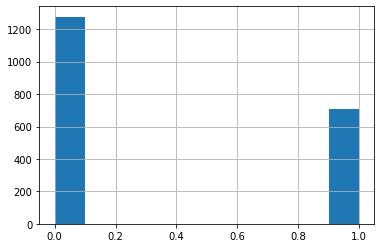

In [12]:
trv['trv_insu'].hist() # 크게 inbalancing하지는 않다.

In [13]:
# 비율 crosstab
for col in trv.columns:
    print(pd.crosstab(trv['trv_insu'], trv[col]))

Unnamed: 0  0     1     2     3     4     5     6     7     8     9     ...  \
trv_insu                                                                ...   
0              1     1     0     1     1     1     1     0     0     1  ...   
1              0     0     1     0     0     0     0     1     1     0  ...   

Unnamed: 0  1977  1978  1979  1980  1981  1982  1983  1984  1985  1986  
trv_insu                                                                
0              0     0     1     1     0     0     1     1     0     1  
1              1     1     0     0     1     1     0     0     1     0  

[2 rows x 1987 columns]
age       25.0  26.0  27.0  28.0  29.0  30.0  31.0  32.0  33.0  34.0  35.0
trv_insu                                                                  
0           54    74   104   401   141    37   159    72    70   133    32
1           82    74    27   105    51    28    75    19    78   133    26
hire_type  민 간  민.간   민간   정부
trv_insu                     
0     

## Unique

In [14]:
trv.nunique()

Unnamed: 0    1987
age             11
hire_type        4
college          2
income          30
family           9
disease          2
paid             2
exper            2
trv_insu         2
dtype: int64

In [15]:
uniq_col = trv.columns
print(uniq_col)
for col in uniq_col:
    print(f"{col}:", np.unique(trv[col]))
    
# Error--- '<' not supported between instances of 'float' and 'str' (눈으로만 확인)

Index(['Unnamed: 0', 'age', 'hire_type', 'college', 'income', 'family',
       'disease', 'paid', 'exper', 'trv_insu'],
      dtype='object')
Unnamed: 0: [   0    1    2 ... 1984 1985 1986]
age: [25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. nan]
hire_type: ['민 간' '민.간' '민간' '정부']
college: ['No' 'Yes']
income: [ 300000  350000  400000  450000  500000  550000  600000  650000  700000
  750000  800000  850000  900000  950000 1000000 1050000 1100000 1150000
 1200000 1250000 1300000 1350000 1400000 1450000 1500000 1550000 1650000
 1700000 1750000 1800000]
family: ['2' '3' '4' '5' '6' '7' '8' '9' 'NAN']
disease: [0 1]
paid: ['No' 'Yes']


TypeError: '<' not supported between instances of 'float' and 'str'

#### To-Do: 고용타입: 민.간 민 간 -> 민간 / 가족수: 'NAN' -> np.nan / unnamed: drop

## 고용타입 정제

In [16]:
trv.loc[ (trv['hire_type']=='민 간')|(trv['hire_type']=='민.간')  , 'hire_type']='민간'
trv['hire_type'].nunique()

2

In [17]:
trv.loc[ (trv['family']=='NAN')  , 'family']=np.nan
trv['family']=trv['family'].astype(float)
trv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1987 entries, 0 to 1986
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  1987 non-null   int64  
 1   age         1975 non-null   float64
 2   hire_type   1987 non-null   object 
 3   college     1987 non-null   object 
 4   income      1987 non-null   int64  
 5   family      1986 non-null   float64
 6   disease     1987 non-null   int64  
 7   paid        1987 non-null   object 
 8   exper       1957 non-null   object 
 9   trv_insu    1987 non-null   int64  
dtypes: float64(2), int64(4), object(4)
memory usage: 155.4+ KB


#### To-Do: 가족 null값 처리

## Unnamed: 0 제거

In [18]:
trv=trv.drop('Unnamed: 0', axis=1)

## Distribution 확인

In [19]:
trv.describe()

,age,income,family,disease,trv_insu
count,1975.000000,1.987000e+03,1986.000000,1987.000000,1987.000000
mean,29.668354,9.327630e+05,4.753273,0.277806,0.357323
std,2.898290,3.768557e+05,1.609966,0.448030,0.479332
min,25.000000,3.000000e+05,2.000000,0.000000,0.000000
25%,28.000000,6.000000e+05,4.000000,0.000000,0.000000
50%,29.000000,9.000000e+05,5.000000,0.000000,0.000000
75%,32.000000,1.250000e+06,6.000000,1.000000,1.000000
max,35.000000,1.800000e+06,9.000000,1.000000,1.000000


<AxesSubplot:>

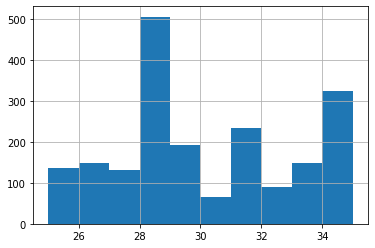

In [20]:
trv['age'].hist()

<AxesSubplot:>

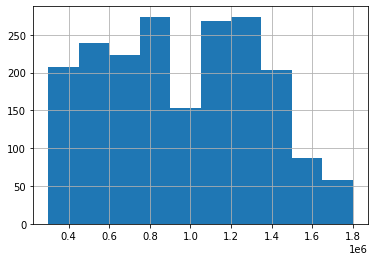

In [21]:
trv['income'].hist()

# Feature Engeineering

## Object 처리

In [22]:
# get_dummies
trv['hire_type'].value_counts()
trv['hire_public']=trv['hire_type'].apply(lambda x : 1 if x=='정부' else 0)
trv=trv.drop('hire_type', axis=1)
trv.head()

,age,college,income,family,disease,paid,exper,trv_insu,hire_public
0,31.0,Yes,400000,6.0,1,No,No,0,1
1,31.0,Yes,1250000,7.0,0,No,No,0,0
2,34.0,Yes,500000,4.0,1,No,No,1,0
3,28.0,Yes,700000,3.0,1,No,No,0,0
4,28.0,Yes,700000,8.0,1,Yes,No,0,0


In [23]:
# get_dummies
trv['college'].value_counts()
trv['college']=trv['college'].apply(lambda x : 1 if x=='Yes' else 0)
trv.head()

,age,college,income,family,disease,paid,exper,trv_insu,hire_public
0,31.0,1,400000,6.0,1,No,No,0,1
1,31.0,1,1250000,7.0,0,No,No,0,0
2,34.0,1,500000,4.0,1,No,No,1,0
3,28.0,1,700000,3.0,1,No,No,0,0
4,28.0,1,700000,8.0,1,Yes,No,0,0


In [24]:
trv['family'].value_counts()

4.0    504
5.0    426
3.0    377
6.0    294
7.0    178
2.0     93
8.0     59
9.0     55
Name: family, dtype: int64

In [25]:
# get_dummies
trv['paid'].value_counts()
trv['paid']=trv['paid'].apply(lambda x : 1 if x=='Yes' else 0)
trv.head()

,age,college,income,family,disease,paid,exper,trv_insu,hire_public
0,31.0,1,400000,6.0,1,0,No,0,1
1,31.0,1,1250000,7.0,0,0,No,0,0
2,34.0,1,500000,4.0,1,0,No,1,0
3,28.0,1,700000,3.0,1,0,No,0,0
4,28.0,1,700000,8.0,1,1,No,0,0


In [26]:
# get_dummies
trv['exper'].value_counts()
trv['exper']=trv['exper'].apply(lambda x : 1 if x=='Yes' else 0)
trv.head()

,age,college,income,family,disease,paid,exper,trv_insu,hire_public
0,31.0,1,400000,6.0,1,0,0,0,1
1,31.0,1,1250000,7.0,0,0,0,0,0
2,34.0,1,500000,4.0,1,0,0,1,0
3,28.0,1,700000,3.0,1,0,0,0,0
4,28.0,1,700000,8.0,1,1,0,0,0


## Null 처리

In [27]:
trv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1987 entries, 0 to 1986
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          1975 non-null   float64
 1   college      1987 non-null   int64  
 2   income       1987 non-null   int64  
 3   family       1986 non-null   float64
 4   disease      1987 non-null   int64  
 5   paid         1987 non-null   int64  
 6   exper        1987 non-null   int64  
 7   trv_insu     1987 non-null   int64  
 8   hire_public  1987 non-null   int64  
dtypes: float64(2), int64(7)
memory usage: 139.8 KB


### age

0    28.0
dtype: float64

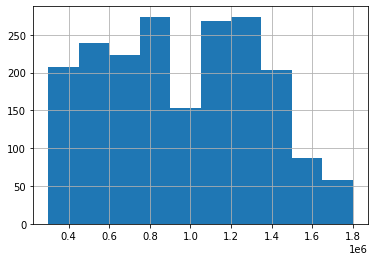

In [28]:
# mode로 fillna하려면 .values[0] 붙여야 됨!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

trv['age'].isna().sum()
# trv['age'].hist()
trv['income'].hist()
trv.loc[trv['age'].isna(), 'income']
trv.loc[trv['income']==1700000, 'age'].mode() # 25
trv.loc[trv['income']==1150000, 'age'].mode() # 28
trv.loc[trv['income']==1100000, 'age'].mode()# 28
trv.loc[trv['income']==1400000, 'age'].mode()# 26
trv.loc[trv['income']==750000, 'age'].mode() # 28 

In [29]:
# trv.loc[trv['income']==1700000, 'age'].fillna(25, inplace=True)# 25
# trv.loc[trv['income']==1150000, 'age'].fillna(28) # 28
# trv.loc[trv['income']==1100000, 'age'].fillna(28)# 28
# trv.loc[trv['income']==1400000, 'age'].fillna(26)# 26
# trv.loc[trv['income']==750000, 'age'].fillna(28)# 28 

In [30]:
trv["age"].fillna(trv.groupby(by="income")["age"].transform("mean"),inplace=True)

In [31]:
trv['age'].isna().sum()

0

In [32]:
trv['age']=trv['age'].astype(int)

### family

In [33]:
# 한 개이므로 최빈값으로 채움
# fam_mode=trv['family'].mode()
# fam_mode # 4.0
trv['family']=trv['family'].fillna(4.0)
trv['family']=trv['family'].astype('int')

## 확인

In [34]:
trv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1987 entries, 0 to 1986
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   age          1987 non-null   int32
 1   college      1987 non-null   int64
 2   income       1987 non-null   int64
 3   family       1987 non-null   int32
 4   disease      1987 non-null   int64
 5   paid         1987 non-null   int64
 6   exper        1987 non-null   int64
 7   trv_insu     1987 non-null   int64
 8   hire_public  1987 non-null   int64
dtypes: int32(2), int64(7)
memory usage: 124.3 KB


# 1차 모형분석

In [35]:
X=trv.drop('trv_insu', axis=1)
y=trv['trv_insu']

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1024)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1490, 8) (497, 8) (1490,) (497,)


In [37]:
model=RandomForestClassifier(random_state=1024)
model.fit(X_train, y_train)
pred = model.predict(X_test)

In [38]:
roc_auc_score(y_test, pred, average="macro")

0.7444473870056497

In [39]:
f1_score(y_test, pred, average="macro")

0.753838533927687

In [40]:
# model=LogisticRegression(penalty="l2")
# model.fit(X_train, y_train)
# pred = model.predict(X_test)

In [41]:
# roc_auc_score(y_test, pred)

In [42]:
# f1_score(y_test, pred)

# 튜닝

In [43]:
model=RandomForestClassifier(random_state=1024)
myparam = {'n_estimators':[30, 50, 100,200, 300]}
gcv=GridSearchCV(model, param_grid=myparam, scoring="roc_auc", cv=5)
gcv.fit(X_train, y_train)
pred = gcv.predict(X_test)
auc = roc_auc_score(y_test, pred, average='macro')

In [44]:
print(f"GCV auc 점수 {auc:.4f}")

GCV auc 점수 0.7401


In [45]:
myparam = {'n_estimators':[30, 50, 100,200, 300]}
gcv=GridSearchCV(model, param_grid=myparam, scoring="f1_macro", cv=5)
gcv.fit(X_train, y_train)
pred = gcv.predict(X_test)
f1 = f1_score(y_test, pred, average='macro')


In [46]:
print(f"GCV f1 점수 {f1:.4f}")

GCV f1 점수 0.7492


# OverSampling

In [47]:
smote=SMOTE(random_state=1024)

In [48]:
over_X, over_y = smote.fit_resample(X,y)

In [49]:
over_X_train, over_X_test, over_y_train, over_y_test = train_test_split(over_X, over_y, random_state=1024)
print(over_X_train.shape, over_X_test.shape, over_y_train.shape, over_y_test.shape)

(1915, 8) (639, 8) (1915,) (639,)


In [50]:
model=RandomForestClassifier(random_state=1024)
myparam = {'n_estimators':[30, 50, 100,200, 300]}
gcv=GridSearchCV(model, param_grid=myparam, scoring="roc_auc", cv=5)
gcv.fit(over_X_train, over_y_train)
over_pred = gcv.predict(over_X_test)
auc = roc_auc_score(over_y_test, over_pred, average='macro')

In [51]:
print(f"GCV auc 점수 {auc:.4f}")

GCV auc 점수 0.7613


In [52]:
model=RandomForestClassifier(random_state=1024)
myparam = {'n_estimators':[30, 50, 100,200, 300]}
gcv=GridSearchCV(model, param_grid=myparam, scoring="f1_macro", cv=5)
gcv.fit(over_X_train, over_y_train)
over_pred = gcv.predict(over_X_test)
f1 = roc_auc_score(over_y_test, over_pred, average='macro')

In [53]:
print(f"GCV f1 점수 {f1:.4f}")

GCV f1 점수 0.7600


# 변수 분석

array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'college'}>,
        <AxesSubplot:title={'center':'income'}>],
       [<AxesSubplot:title={'center':'family'}>,
        <AxesSubplot:title={'center':'disease'}>,
        <AxesSubplot:title={'center':'paid'}>],
       [<AxesSubplot:title={'center':'exper'}>,
        <AxesSubplot:title={'center':'trv_insu'}>,
        <AxesSubplot:title={'center':'hire_public'}>]], dtype=object)

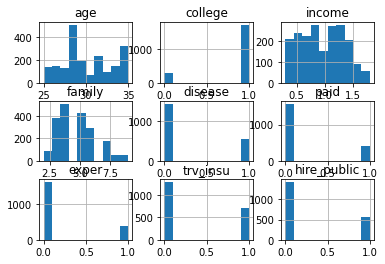

In [54]:
trv.hist()

In [55]:
trv.corr()
# trv_insu는 income과 exper과 높은 상관관계
# exepr과 income도 높은 상관관계 -> 하나로 합치자 / incme이 더 정보 많아보임

,age,college,income,family,disease,paid,exper,trv_insu,hire_public
age,1.000000,0.027040,-0.017851,0.027090,0.008121,-0.033655,-0.008317,0.062244,0.112103
college,0.027040,1.000000,0.108066,0.021201,0.018811,-0.028120,0.062683,0.018934,0.127133
income,-0.017851,0.108066,1.000000,-0.015367,-0.001149,0.353087,0.486043,0.396763,-0.349157
family,0.027090,0.021201,-0.015367,1.000000,0.028209,-0.023775,-0.020755,0.079909,0.003354
disease,0.008121,0.018811,-0.001149,0.028209,1.000000,-0.043720,0.021238,0.018190,0.011553
paid,-0.033655,-0.028120,0.353087,-0.023775,-0.043720,1.000000,0.277334,0.232103,-0.143790
exper,-0.008317,0.062683,0.486043,-0.020755,0.021238,0.277334,1.000000,0.433183,-0.181098
trv_insu,0.062244,0.018934,0.396763,0.079909,0.018190,0.232103,0.433183,1.000000,-0.147847
hire_public,0.112103,0.127133,-0.349157,0.003354,0.011553,-0.143790,-0.181098,-0.147847,1.000000


In [56]:
## 방법 1) exper drop

In [57]:
def my_ml(data):
    X=data.drop('trv_insu', axis=1)
    y=data['trv_insu']
    
    smote=SMOTE(random_state=1024)
    over_X, over_y = smote.fit_resample(X,y)
    over_X_train, over_X_test, over_y_train, over_y_test = train_test_split(over_X, over_y, random_state=1024)

    model=RandomForestClassifier(random_state=1024)
    myparam = {'n_estimators':[30, 50, 100,200, 300]}
    gcv=GridSearchCV(model, param_grid=myparam, scoring="roc_auc", cv=5)
    gcv.fit(over_X_train, over_y_train)
    over_pred = gcv.predict(over_X_test)
    auc1 = roc_auc_score(over_y_test, over_pred, average='macro')
    print(f"GCV auc 점수 {auc1:.4f}")
    
    model=RandomForestClassifier(random_state=1024)
    myparam = {'n_estimators':[30, 50, 100,200, 300]}
    gcv=GridSearchCV(model, param_grid=myparam, scoring="f1_macro", cv=5)
    gcv.fit(over_X_train, over_y_train)
    over_pred = gcv.predict(over_X_test)
    f11 = roc_auc_score(over_y_test, over_pred, average='macro')
    print(f"GCV f1 점수 {f11:.4f}")

In [58]:
trv_drop_exper=trv.drop('exper', axis=1)
my_ml(trv_drop_exper)

GCV auc 점수 0.7693
GCV f1 점수 0.7635


In [59]:
## 방법 2) income drop

In [60]:
# trv_drop_income=trv.drop('income', axis=1)
# my_ml(trv_drop_income)

# Income Scaling

In [61]:
trv['log_income']=np.log1p(trv['income'])

In [62]:
trv_log1p=trv.drop(['income','exper'] , axis=1)

In [63]:
my_ml(trv_log1p)

GCV auc 점수 0.7667
GCV f1 점수 0.7672


# XGBoost

In [ ]:
from xgboost import XGBClassifier

In [65]:
X=trv.drop('trv_insu', axis=1)
y=trv['trv_insu']

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1024, test_size=0.3) # test_size 조정 가능

In [67]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1390, 9) (597, 9) (1390,) (597,)


In [68]:
from xgboost import XGBClassifier # class -> XGBModel을 상속받음
# xgb=XGBClassifier()

In [72]:
# 사이킷런에서 model -> xgb로 설정한 거라 생각하면 됨
xgb=XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=1024)
xgb.fit(X_train, y_train)
pred=xgb.predict(X_test)
f1=f1_score(y_test, pred, average='macro')
# acc=accuracy_score(y_test, pred)
print(f"f1: {f1:.4f}")
# cm=confusion_matrix(y_test, pred)
# print(cm)

# 왜 나는 똑같냐...

[13:17:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
f1: 0.7726


c:\ai\pythonproject\venv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
